In [1]:
import os
import audiolabel
import ultratils.pysonix.bprreader

import pandas as pd
import numpy as np
import parselmouth

import scipy.signal as sg
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
datadir = os.path.abspath('./data/')

For this notebook, let's just have a look at one recording.  Arbitrarily, I've chosen to look at Subject 121, a female presenting speaker, saying the phrase "I'm a Lee".  
- Vocalization begins at 0.585 s (frame 41) and ends around 1.283 (frame 112).
- "Lee" begins around 0.907 (frame 75).
- The frame rate of the recording is ~113Hz, with 8.8ms between frames.
- There are many missing frames, as is usual for the settings, ocurring approximately every 9 frames.

In [3]:
testsubj = '121'
testcase = '2015-10-30T104028-0700'

# read in the BPR
bprloc = os.path.join(datadir, testsubj, testcase, testcase+'.bpr')
bpr = ultratils.pysonix.bprreader.BprReader(bprloc)

# read in the audio
auloc = os.path.join(datadir, testsubj, testcase, testcase+'.bpr.wav')
au = parselmouth.Sound(auloc)
au = au.extract_channel(1)

In [7]:
# read in the known synchronization data, and create a dataframe to add to
syncloc = os.path.join(datadir, testsubj, testcase, testcase+'.bpr.sync.txt')

# the first tier in this object is the number of the pulse, the second is the actual frame number
frame_times = audiolabel.LabelManager(from_file = syncloc, from_type='table', t1_col='seconds').as_df()[1]
frame_times = frame_times.rename(columns={'text':'frameN','t1':'time'})
frame_times.head()

,time,frameN
0,0.1746,0
1,0.1834,1
2,0.1922,2
3,0.2011,3
4,0.2099,4


Let's look at just one frame.  Here's the raw image data (left) and the same data with median filtering applied (right).  The addition of filtering definitely smooths out the image but I'm not sure how much it adds.

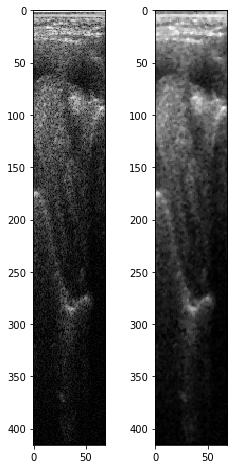

In [5]:
fig=plt.figure(figsize=(4,8))
fig.add_subplot(1, 2, 1)
plt.imshow(bpr.get_frame(28), cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(sg.medfilt(bpr.get_frame(28)), cmap='gray')

Let's gather up all of the available frames from the ultrasound data into a list, and then subtract each frame from the last.  This will generate a sort of first differential -- change in ultrasound image over time.

In [4]:
frames = [bpr.get_frame(i) for i in range(0, bpr.nframes)]
frames_med = [sg.medfilt(bpr.get_frame(i)) for i in range(0, bpr.nframes)] # with filtering

In [5]:
frames_diff = [np.mean(np.abs(frames[i]-frames[i-1])) for i in range(1, len(frames))]
frames_diff_med = [np.mean(np.abs(frames_med[i]-frames_med[i-1])) for i in range(1, len(frames_med))]

In [9]:
frame_times['diff_raw'] = frame_times['frameN'].apply(lambda x: frames_diff[int(x)-1] if (x!='NA' and int(x)>0) else np.nan)
frame_times['diff_med'] = frame_times['frameN'].apply(lambda x: frames_diff_med[int(x)-1] if (x!='NA' and int(x)>0) else np.nan)
frame_times.head()

,time,frameN,diff_raw,diff_med
0,0.1746,0,NaN,NaN
1,0.1834,1,7.165482,4.304383
2,0.1922,2,7.180219,4.043827
3,0.2011,3,7.943144,4.335598
4,0.2099,4,8.657086,4.599533


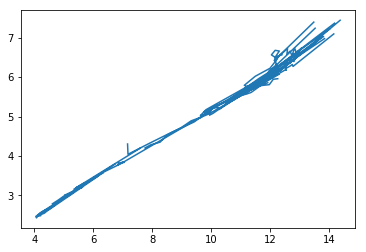

In [9]:
plt.plot('diff_raw','diff_med',data=frame_times)

Looks like there's not much difference though between the differential functions with or without the filtering.  So from this point on, we'll use the raw (unfiltered) differential.

First let's just look at the ultrasound differential over time.

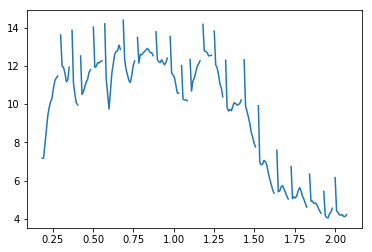

In [10]:
plt.plot('time','diff_raw',data=frame_times)

Nice.  But what are the spikes?  Looks like they all occur after a missing frame.  This makes some sense, in that if finding the difference between two frames that are actually 2 units of time apart, they will be _more_ different than two frames that are 1 unit apart.  What's interesting though is that they aren't all simply _double_.  So we can't just divide these spikes by the number of time units between the two frames compared and distribute those values between them.  Let's see what that happens to look like.

At first this feels wrong.  If there's twice as much time between the frames compared, shouldn't each spike be about twice as different from each other?  However, I think perhaps the best way to think about this is that the way the difference is calculated, if the tongue is moving at a steady pace, the difference between the missing frame and the two frames on either side shouldn't actually be double, they should be roughly the same, since it's just a difference of _where_ the bright pixels have moved to.  Thus, the spikes probably represent some general noisy speckliness in the data.

To fix this, let's try just removing those points and forging ahead.

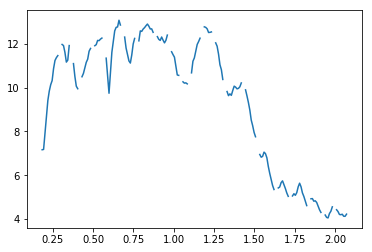

In [12]:
cordiff = [np.nan]
nalen = 0
for i in range(1, len(frame_times)):
    if frame_times['frameN'][i-1]=='NA':
        cordiff = cordiff + [np.nan]
    else:
        cordiff = cordiff + [frame_times['diff_raw'][i]]
        
frame_times['cordiff'] = cordiff
plt.plot('time','cordiff',data=frame_times)

Ok now let's try to get a similar representation of the changes to the acoustic signature over time!

In [11]:
pmfcc = au.to_mfcc()
mfcc = np.transpose(pmfcc.to_array())  # transpose this to get time (frames) on the first dimension

In [13]:
au_diff = [np.mean(np.abs(mfcc[i]-mfcc[i-1])) for i in range(1, len(mfcc))]

In [14]:
frame_times['au_diff']=frame_times.time.apply(lambda x: au_diff[int(pmfcc.get_frame_number_from_time(x)+1)])
frame_times['au_logdiff']=frame_times.au_diff.apply(lambda x: np.log(x))
frame_times.head()

,time,frameN,diff_raw,diff_med,cordiff,au_diff,au_logdiff
0,0.1746,0,NaN,NaN,NaN,10.847160,2.383903
1,0.1834,1,7.165482,4.304383,7.165482,10.379678,2.339850
2,0.1922,2,7.180219,4.043827,7.180219,14.116009,2.647310
3,0.2011,3,7.943144,4.335598,7.943144,11.952786,2.480964
4,0.2099,4,8.657086,4.599533,8.657086,13.448129,2.598840


## Hypothesis 1a (naive)
Changes in the ultrasound should correlate with changes in the audio.

To test this, let's just plot the two differentials together and see if they look similar at all in their shape or curve.

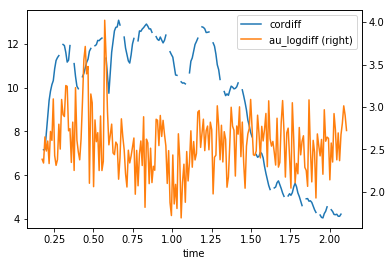

In [15]:
fig = frame_times.plot(x='time',y='cordiff')
frame_times.plot(x='time',y='au_logdiff',secondary_y=True,ax=fig)

In [16]:
segtgfile = os.path.join(datadir, 'textgrids', testsubj, testcase+'.TextGrid')
segtg = audiolabel.LabelManager(from_file=segtgfile, from_type='praat')
segtg.tier('phone')

IntervalTier([Label( t1=0.0125, t2=0.5512, text='b'sp'' ),Label( t1=0.5512, t2=0.6909, text='b'AY1'' ),Label( t1=0.6909, t2=0.7707, text='b'M'' ),Label( t1=0.7707, t2=0.8306, text='b'AH0'' ),Label( t1=0.8306, t2=0.9404, text='b'L'' ),Label( t1=0.9404, t2=1.2696, text='b'IY1'' ),Label( t1=1.2696, t2=2.2973, text='b'sp'' )])

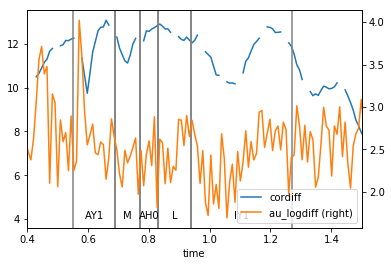

In [17]:
fig = frame_times.plot(x='time',y='cordiff',xlim=[.4,1.5])
frame_times.plot(x='time',y='au_logdiff',secondary_y=True,ax=fig)
for p in [p for p in segtg.tier('phone') if p.text!='sp']:
    fig.axvline(p.t1,color='gray')
    fig.text((p.center),4,p.text, horizontalalignment='center')
    fig.axvline(p.t2,color='gray')


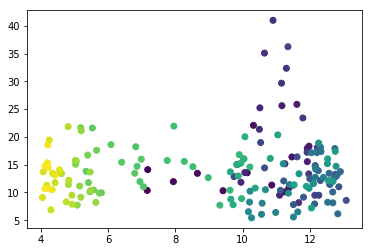

In [18]:
plt.scatter(x='cordiff',y='au_diff',data=frame_times,c='time')

Well, that doesn't look like much is going on by way of correlation between the audio and the ultrasound differentials.  Let's just make sure that they're poorly coorelated.

In [ ]:
stats.linregress(x=frame_times['cordiff'],y=frame_times['au_diff'])

NaNs returned because there are NaN values in the dataset (from missing ultrasound frames), so we need to run the regression on only valid data.

And... oof.  _r=0.05_ and _p=0.5208_.

In [20]:
validdf = frame_times[(frame_times['cordiff'] > 0) & (frame_times['au_diff'] > 0)]
stats.linregress(x=validdf['cordiff'], y=validdf['au_diff'])

LinregressResult(slope=0.09007534592803085, intercept=13.068722440326532, rvalue=0.04914265909523971, pvalue=0.5208258165718833, stderr=0.13999875905122125)

## Hypothesis 1b (a bit less naive)
There should be _some period of time_ during the acquisition where changes in the ultrasound do correlate well with changes in the audio.

It makes sense that if we were to look at _all_ of the data at once, the correlation between articulatory and acoustic differential signals would be poor.  Hypothesis 1a was too naive.  So let's take periods of 250ms -- these can be arbitrarily long or short -- and check how well they're correlated within those periods.

In [23]:
duration = .2
rs = []
ps = []

starttimes = [t for t in validdf['time'] if t+duration < np.max(validdf['time'])]

for starttime in starttimes:
    subdf = validdf[(validdf['time'] >= starttime-duration/2) & (validdf['time'] <= starttime+duration/2)]
    sts = stats.linregress(x=subdf['cordiff'], y=subdf['au_diff'])
    rs = rs + [sts.rvalue]
    ps = ps + [sts.pvalue]

validdf['r'] = pd.Series(rs)
validdf['p'] = pd.Series(ps)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


This is promising!  This shows that even with the pretty weak calculus employed above for calculating audio and ultrasound derivatives, there is a ~200ms period where the correlation between audio and ultrasound is quite good (low p-value _and_ high r).

In [ ]:
fig = validdf.plot(x='time',y='r',xlim=[.4,1.4])
validdf.plot(x='time',y='p',secondary_y=True,ax=fig)
for p in [p for p in segtg.tier('phone') if p.text!='sp']:
    fig.axvline(p.t1,color='gray')
    fig.text((p.center),-.4,p.text, horizontalalignment='center')
    fig.axvline(p.t2,color='gray')
fig.savefig('test.pdf')

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

In [ ]:
validdf[validdf.p<0.05]

## Hypothesis 2
The period of time during which changes in ultrasound and changes in audio are correlated well should be strongest/longest when the audio and ultrasound is correctly syncronized.

Next, we need to check whether desynchronizing the audio from the ultrasound results in poorer correlation over time.  (Hopefully it does.)  First though, let's make a function out of the important part of the process above.

In [ ]:
# bpr: BPR file
# au: Parselmouth Sound object, mono
# sync: LabelManager object
# windowlen: window length for analysis, in seconds
def syncmatch(bpr, au, syncloc, windowlen=0.25):

    frame_times = audiolabel.LabelManager(from_file = syncloc, from_type='table', t1_col='seconds').as_df()[1]
    frame_times = frame_times.rename(columns={'text':'frameN','t1':'time'})

    frames = [bpr.get_frame(i) for i in range(0, bpr.nframes)]
    frames_diff = [np.mean(np.abs(frames[i]-frames[i-1])) for i in range(1, len(frames))]
    
    frame_times['us_diff'] = frame_times['frameN'].apply(lambda x: frames_diff[int(x)-1] 
                                                         if (x!='NA' and int(x)>0) else np.nan)
    for i in range(1, len(frame_times)):
        if frame_times['frameN'][i-1]=='NA':
            frame_times.loc[i,'us_diff']=np.nan
   
    pmfcc = au.to_mfcc()
    mfcc = np.transpose(pmfcc.to_array())  # transpose this to get time (frames) on the first dimension

    au_diff = [np.mean(np.abs(mfcc[i]-mfcc[i-1])) for i in range(1, len(mfcc))]
    frame_times['au_diff']=frame_times.time.apply(lambda x: au_diff[int(pmfcc.get_frame_number_from_time(x)+1)])

    validdf = frame_times[(frame_times['us_diff'] > 0) & (frame_times['au_diff'] > 0)].reset_index()
    rs = []
    ps = []
    starttimes = [t for t in validdf['time'] if t+windowlen < np.max(validdf['time'])]
    for starttime in starttimes:
        subdf = validdf[(validdf['time'] >= starttime) & (validdf['time'] <= starttime+windowlen)]
        sts = stats.linregress(x=subdf['us_diff'], y=subdf['au_diff'])
        rs = rs + [sts.rvalue]
        ps = ps + [sts.pvalue]

    validdf = pd.concat([validdf,pd.DataFrame({'r':rs})], ignore_index=False, axis=1)
    validdf = pd.concat([validdf,pd.DataFrame({'p':ps})], ignore_index=False, axis=1)

    return validdf

Just to make sure this works as intended...

In [ ]:
testdf = syncmatch(bpr, au, syncloc)
testdf

In [ ]:
fig = testdf.plot(x='time',y='r')
testdf.plot(x='time',y='p',secondary_y=True,ax=fig)

Looks good!  Now, we'll make a function to determine how long of a "match streak" we can find in the data.  I.e., how many continguous frames show a low p-value and high r-value?

In [ ]:
def matchstreak(syncdf, p_crit=0.05, r_crit=0.5):

    inrange=False
    streak=0
    maxstreak=0
    streakonset=[]
    streakoffset=[]
    for i in range(0, len(syncdf)-1):
        if syncdf.p[i]<p_crit and syncdf.r[i]>r_crit:
            if inrange:
                streak+=1
            else:
                inrange=True
                streak=1
                streakonset = streakonset+[syncdf.time[i]]
        else:
            if inrange:
                inrange=False
                streakoffset = streakoffset+[syncdf.time[i]]
        maxstreak=max(maxstreak,streak)

    return (maxstreak, streakonset, streakoffset)

Now we want to make sure that the true sync works better than when the audio is offset.  This loop creates a new audiofile with an offset as indicated, then attempts to run the matchstreak function.  If successful, it will print out the offset, and the output of matchstreak, which is a tuple containing (max streaklength in frames, onsets of all streaks, offsets of all streaks).

In [ ]:
# testoffsets = np.linspace(-.25,.25,21)
testoffsets = [-0.5,-0.25,-0.1,-0.05,-0.025,-0.01,-0.005,0,0.005,0.01,0.025,0.5,0.1,0.25,0.5]
for offset in testoffsets:
    testau = au.copy()
    testau.shift_times_by(offset)
    try:    
        m = matchstreak(syncmatch(bpr, testau, syncloc),p_crit=0.01,r_crit=0.6)
        print('\t'.join([str(offset),str(m)]))
    except:
        print('\t'.join([str(offset),'error']))

Not bad!  We can see the longest streak occurs at 0, and only the 5 and 25ms offsets even come close to competing.

But now we should test more files....  Scary!